## Setup Proyek dan Impor Library

In [ ]:
# ==============================================================================
# SETUP DAN IMPOR LIBRARY
# ==============================================================================
# Library inti
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2  # OpenCV
from PIL import Image
from tqdm.auto import tqdm
import time

# --- Library untuk Feature Engineering (Total 5 Fitur) ---
from skimage.feature import graycomatrix, graycoprops, hog, local_binary_pattern
from scipy.stats import skew, kurtosis

# --- Library untuk Machine Learning Klasik ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import class_weight

# --- Library untuk Penanganan Ketidakseimbangan ---
# Jika Anda belum punya, jalankan: pip install imbalanced-learn
try:
    from imblearn.over_sampling import SMOTE
except ImportError:
    print("WARNING: Modul 'imbalanced-learn' tidak ditemukan. SMOTE (Metode B) akan gagal.")
    print("Silakan instal dengan: pip install imbalanced-learn")

# 5 Model Klasik (Sesuai Permintaan)
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB # Tambahan 1 & 2

# --- Konfigurasi Global ---
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7) # Ukuran plot lebih besar
plt.style.use("fivethirtyeight")
plt.rcParams['figure.dpi'] = 100

print(f"✅ Library lengkap (termasuk imbalanced-learn) berhasil diimpor.")

✅ Library lengkap (termasuk imbalanced-learn) berhasil diimpor.


## EDA

✅ GroundTruth file loaded successfully. 11 classes detected.

--- CLASS DISTRIBUTION ANALYSIS (IMBALANCE ISSUE) ---
| Class   |   Count |   Percentage (%) |
|:--------|--------:|-----------------:|
| BCC     | 2522.00 |            48.13 |
| NV      |  746.00 |            14.24 |
| BKL     |  544.00 |            10.38 |
| SCCKA   |  473.00 |             9.03 |
| MEL     |  450.00 |             8.59 |
| AKIEC   |  303.00 |             5.78 |
| DF      |   52.00 |             0.99 |
| INF     |   50.00 |             0.95 |
| VASC    |   47.00 |             0.90 |
| BEN_OTH |   44.00 |             0.84 |
| MAL_OTH |    9.00 |             0.17 |


c:\Users\bayua\miniconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\bayua\miniconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\bayua\miniconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


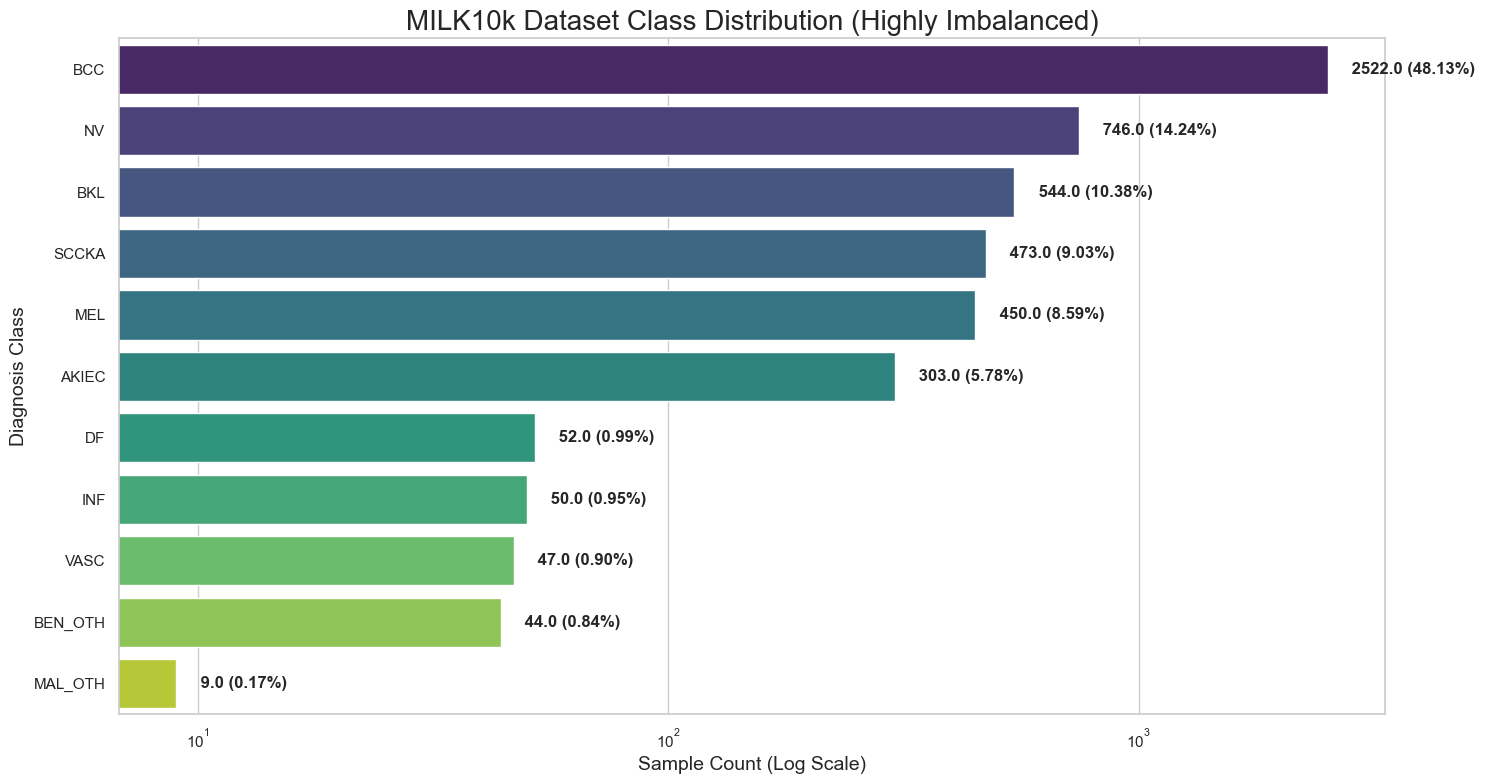

In [ ]:
# ==============================================================================
# CELL 2: EDA - CLASS DISTRIBUTION ANALYSIS
# ==============================================================================
# This cell performs the initial Exploratory Data Analysis on the class labels

train_truth_path = "../dataset/MILK10k_Training_GroundTruth.csv"
train_meta_path = "../dataset/MILK10k_Training_Metadata.csv"

BASE_IMAGE_PATH = "../dataset/MILK10k_Training_Input"

try:
    df_train_truth = pd.read_csv(train_truth_path)
    DIAGNOSIS_COLUMNS = df_train_truth.columns.drop('lesion_id')
    NUM_CLASSES = len(DIAGNOSIS_COLUMNS)
    print(f"✅ GroundTruth file loaded successfully. {NUM_CLASSES} classes detected.")
    
    # --- Class Distribution Analysis ---
    class_counts = df_train_truth[DIAGNOSIS_COLUMNS].sum()
    class_percentage = (class_counts / len(df_train_truth)) * 100
    
    df_distribusi = pd.DataFrame({
        'Class': class_counts.index,
        'Count': class_counts.values,
        'Percentage (%)': class_percentage.values
    }).sort_values(by='Count', ascending=False)
    
    print("\n--- CLASS DISTRIBUTION ANALYSIS (IMBALANCE ISSUE) ---")
    print(df_distribusi.to_markdown(index=False, floatfmt=".2f"))
    
    # --- Class Distribution Visualization ---
    plt.figure(figsize=(15, 8))
    ax = sns.barplot(
        data=df_distribusi, 
        x='Count', 
        y='Class', 
        palette='viridis',
        orient='h'
    )
    plt.title("MILK10k Dataset Class Distribution (Highly Imbalanced)", fontsize=20)
    plt.xlabel("Sample Count (Log Scale)", fontsize=14)
    plt.ylabel("Diagnosis Class", fontsize=14)
    ax.set_xscale("log") # Use log scale due to extreme differences
    
    # Add labels
    for i, (count, pct) in enumerate(zip(df_distribusi['Count'], df_distribusi['Percentage (%)'])):
        ax.text(count * 1.1, i, f" {count} ({pct:.2f}%)", va='center', fontsize=12, fontweight='bold')
        
    plt.tight_layout()
    plt.show()

except FileNotFoundError as e:
    print(f"❌ ERROR: CSV file not found. Make sure '{train_truth_path}' is in the correct folder.")
    DIAGNOSIS_COLUMNS = []
    df_train_truth = pd.DataFrame()

## MEMUAT METADATA & SPLIT DATA

In [ ]:
# ==============================================================================
# MEMUAT METADATA & SPLIT DATA
# ==============================================================================

try:
    df_train_meta = pd.read_csv(train_meta_path)
    print("✅ File Metadata berhasil dimuat.")

    # --- 3.1 Transformasi Data & Pembuatan Path Gambar ---
    def transform_to_wide_format(df_meta, image_base_path):
        df_meta['full_path'] = df_meta.apply(
            lambda row: os.path.join(image_base_path, row['lesion_id'], row['isic_id'] + '.jpg').replace("\\", "/"), axis=1
        )
        df_clinical = df_meta[df_meta['image_type'].str.contains('clinical')].add_prefix('clinical_')
        df_dermoscopic = df_meta[df_meta['image_type'].str.contains('dermoscopic')].add_prefix('dermoscopic_')
        df_clinical.rename(columns={'clinical_lesion_id': 'lesion_id'}, inplace=True)
        df_dermoscopic.rename(columns={'dermoscopic_lesion_id': 'lesion_id'}, inplace=True)
        df_wide = pd.merge(
            df_clinical[['lesion_id', 'clinical_full_path']],
            df_dermoscopic[['lesion_id', 'dermoscopic_full_path', 'dermoscopic_isic_id']],
            on='lesion_id'
        )
        df_wide.rename(columns={'dermoscopic_isic_id': 'isic_id'}, inplace=True)
        return df_wide

    df_train_wide = transform_to_wide_format(df_train_meta, BASE_IMAGE_PATH) # Gunakan path yang Anda tentukan
    df_train_processed = pd.merge(df_train_wide, df_train_truth, on='lesion_id')
    print("✅ Data transformed to wide-format.")

    # --- 3.2 Split Data (Stratified) ---
    # Stratified split WAJIB untuk data tidak seimbang
    y_stratify = df_train_processed[DIAGNOSIS_COLUMNS].idxmax(axis=1) # Dapatkan label kelas (string)
    
    train_df, val_df = train_test_split(
        df_train_processed, 
        test_size=0.2, 
        random_state=42, 
        stratify=y_stratify # Gunakan stratifikasi
    )
    print(f"✅ Data split (stratified) menjadi Train ({len(train_df)}) dan Validation ({len(val_df)}).")

except FileNotFoundError as e:
    print(f"❌ ERROR: File Metadata ('{train_meta_path}') tidak ditemukan.")
    train_df, val_df = pd.DataFrame(), pd.DataFrame()
except Exception as e:
    print(f"❌ ERROR saat memproses data: {e}")
    print("   -> Pastikan 'BASE_IMAGE_PATH' di SEL 2 sudah benar.")
    train_df, val_df = pd.DataFrame(), pd.DataFrame()

✅ File Metadata berhasil dimuat.
✅ Data transformed to wide-format.
✅ Data split (stratified) menjadi Train (4192) dan Validation (1048).


## Pipeline Pra-pemrosesan & Feature Engineering

**Pipeline Ekstraksi 5 Fitur**

Bertujuan untuk mengekstrak **lima set fitur numerik klasik** dari setiap gambar dalam *training set* dan *validation set*. Fitur-fitur ini tidak disimpan secara terpisah, melainkan **langsung digabungkan** menjadi satu matriks fitur (misalnya, (N\_sampel, 30)) untuk *langsung* dimasukkan ke dalam model Machine Learning (seperti SVC atau Random Forest).

Pendekatan ini menciptakan vektor fitur yang kaya yang menangkap informasi eksplisit mengenai **warna (RGB & HSV)**, **tekstur makro (GLCM)**, **tekstur mikro (LBP)**, dan **bentuk (HOG)**.

**Fitur yang Diekstrak (Total 30 Fitur):**

1.  **Fitur Warna (RGB):** Statistik orde 1-4 (Mean, Std Dev, Skewness, Kurtosis) dari setiap *channel* RGB. (12 fitur)
2.  **Fitur Tekstur (GLCM):** Properti statistik (Kontras, Korelasi, Energi, Homogenitas, ASM, Dissimilarity) dari GLCM, dirata-ratakan. (6 fitur)
3.  **Fitur Tekstur (HOG):** Statistik (Mean, Std Dev, Kurtosis) dari vektor *Histogram of Oriented Gradients*. (3 fitur)
4.  **Fitur Warna (HSV) (Baru):** Statistik (Mean, Std Dev) dari *channel* Hue, Saturation, dan Value. (6 fitur)
5.  **Fitur Tekstur (LBP) (Baru):** Statistik (Mean, Std Dev, Kurtosis) dari histogram *Local Binary Patterns*. (3 fitur)

**Proses:**

  * Setiap gambar dalam `train_df` dan `val_df` dibaca.
  * Gambar tersebut di-pra-pemrosesan (Resize + CLAHE).
  * Kelima fungsi (`ekstrak_fitur_...`) diterapkan pada gambar yang telah diproses.
  * Hasilnya digabungkan menjadi satu baris (vektor 30-dimensi) per gambar.

**Output:**

  * Dua matriks NumPy: `X_train_features` dan `X_val_features`.
  * Matriks ini kemudian **wajib** melalui `StandardScaler` (menjadi `X_train_scaled`) sebelum dimasukkan ke model ML di langkah berikutnya.

-----

**Justifikasi Pipeline Pra-pemrosesan & Penanganan Data**

Berdasarkan analisis EDA yang mengonfirmasi adanya **ketidakseimbangan kelas yang parah**, pipeline penanganan data lengkap dirancang untuk alur kerja **Machine Learning Klasik** (bukan Deep Learning).

-----

**1. Pengubahan Ukuran (*Resizing*) - Wajib**

  * **Justifikasi:** (Sama) Ukuran 600x450 terlalu besar. Ukuran **224x224** dipilih untuk menstandardisasi input sebelum ekstraksi fitur.
  * **Tindakan:** `muat_dan_praproses_gambar_klasik` menerapkan *resize* pada setiap gambar.

-----

**2. Peningkatan Kontras (*Contrast Enhancement*) - Wajib**

  * **Justifikasi:** (Sama) Menerapkan **CLAHE** akan menyeragamkan kontras dan membantu algoritma HOG dan LBP menangkap fitur bentuk/tekstur yang lebih konsisten.
  * **Tindakan:** `muat_dan_praproses_gambar_klasik` menerapkan `cv2.CLAHE` setelah *resize*.

-----

**3. Augmentasi Data (PERUBAHAN BESAR)**

  * **Justifikasi:** Augmentasi *on-the-fly* (seperti `Flip`, `ColorJitter`, `Dropout`) **secara sengaja DIHAPUS** dari pipeline pra-pemrosesan gambar.
  * **Alasan:** Menerapkan augmentasi acak akan *merusak* konsistensi fitur yang diekstrak (misalnya, HOG akan berubah jika gambar diputar; fitur Warna akan berubah jika `ColorJitter` diterapkan). Hal ini akan menghasilkan dataset fitur yang "kotor".
  * **Tindakan:** Masalah ketidakseimbangan data ditangani **SETELAH** fitur diekstrak, menggunakan dua metode:
    1.  **Metode A:** Pembobotan Kelas (`class_weight='balanced'`) saat melatih model ML.
    2.  **Metode B:** *Oversampling* di ruang fitur menggunakan **SMOTE** pada `X_train_scaled`.

-----

**4. Normalisasi Piksel (PERUBAHAN BESAR)**

  * **Justifikasi:** Normalisasi Z-score (mengubah piksel [0-255] menjadi [-2, 2]) **secara sengaja DIHAPUS**.
  * **Alasan:** Algoritma HOG, GLCM, dan LBP adalah algoritma pemrosesan gambar klasik yang dirancang untuk beroperasi pada rentang piksel [0-255] yang alami. Memberi mereka nilai negatif akan merusak perhitungan fitur.
  * **Tindakan:** Fitur diekstrak dari gambar [0-255] (yang telah di-CLAHE).

-----

**5. Scaling Fitur (LANGKAH BARU YANG WAJIB)**

  * **Justifikasi:** Sebagai *pengganti* Normalisasi Piksel, kita wajib melakukan **Scaling Fitur**. 30 fitur yang diekstrak memiliki rentang yang sangat berbeda (misal, `glcm_contrast` mungkin ribuan, sementara `glcm_correlation` antara 0-1). Model SVC dan Logistic Regression akan gagal jika fitur tidak di-scaling.
  * **Tindakan:** **`StandardScaler`** diterapkan pada `X_train_features` dan `X_val_features` *setelah* semua fitur diekstrak (SEL 5).

-----

**Ringkasan Implementasi Pipeline (Alur Kerja Klasik)**

Tabel berikut merangkum bagaimana alur kerja dalam kode 9-sel diimplementasikan.

| Langkah | Justifikasi | Implementasi dalam Kode (SEL 3-8) |
|:--- |:---|:---|
| **1. Resizing** | Input seragam 224x224. | `muat_dan_praproses_gambar_klasik` (SEL 4) |
| **2. CLAHE** | Meningkatkan kontras lokal untuk fitur yang lebih baik. | `muat_dan_praproses_gambar_klasik` (SEL 4) |
| **3. Feature Extraction** | Ekstrak 5 set fitur (HOG, GLCM, LBP, dll). | `ekstrak_fitur_...` (diterapkan pada gambar [0-255]) (SEL 4 & 5) |
| **4. Feature Scaling** | Menyamakan skala 30 fitur untuk model ML. | `StandardScaler` (diterapkan pada `X_train_features`) (SEL 5) |
| **5. Imbalance Handling** | Mencegah *overfitting* & mengatasi data tidak seimbang. | **Metode A:** `class_weight='balanced'` (SEL 7) <br> **Metode B:** `SMOTE` (pada `X_train_scaled`) (SEL 8) |

In [4]:
# ==============================================================================
# SEL 4: DEFINISI PRA-PEMROSESAN & 5 FITUR ENGINEERING
# ==============================================================================
# Pra-pemrosesan: Resize + CLAHE
# 5 Fitur: RGB, GLCM, HOG, HSV, LBP

IMG_SIZE = (224, 224)

def muat_dan_praproses_gambar_klasik(path, target_size=IMG_SIZE):
    """
    Langkah Pra-pemrosesan: Muat, Resize, Terapkan CLAHE.
    """
    try:
        img_pil = Image.open(path).convert('RGB').resize(target_size, Image.LANCZOS)
        img_bgr = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)
        
        # --- Terapkan CLAHE ---
        img_lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(img_lab)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
        l_clahe = clahe.apply(l)
        img_clahe_lab = cv2.merge((l_clahe, a, b))
        img_clahe_bgr = cv2.cvtColor(img_clahe_lab, cv2.COLOR_LAB2BGR)
        
        # Dapatkan versi RGB dan Grayscale dari gambar yang sudah di-CLAHE
        image_rgb_clahe = cv2.cvtColor(img_clahe_bgr, cv2.COLOR_BGR2RGB)
        image_gray_clahe = cv2.cvtColor(img_clahe_bgr, cv2.COLOR_BGR2GRAY)
        
        return image_rgb_clahe, image_gray_clahe
    
    except Exception as e:
        # Kembalikan placeholder jika gambar korup/tidak ditemukan
        return (np.zeros((target_size[0], target_size[1], 3), dtype=np.uint8),
                np.zeros((target_size[0], target_size[1]), dtype=np.uint8))

# --- FITUR 1: RGB STATS ---
def ekstrak_fitur_warna_rgb(image_rgb):
    """(Fitur 1) Statistik orde 1-4 dari channel RGB."""
    fitur = {}
    for i, nama_kanal in enumerate(['R', 'G', 'B']):
        kanal = image_rgb[:, :, i].ravel()
        fitur[f'rgb_mean_{nama_kanal}'] = np.mean(kanal)
        fitur[f'rgb_std_{nama_kanal}'] = np.std(kanal)
        fitur[f'rgb_skew_{nama_kanal}'] = skew(kanal)
        fitur[f'rgb_kurt_{nama_kanal}'] = kurtosis(kanal)
    return fitur

# --- FITUR 2: GLCM ---
def ekstrak_fitur_glcm(image_gray):
    """(Fitur 2) Fitur GLCM (Tekstur Skala Abu-abu)."""
    glcm = graycomatrix(image_gray.astype(np.uint8), distances=[1, 3, 5], angles=[0, np.pi/4, np.pi/2], symmetric=True, normed=True)
    fitur = {}
    for prop in ['contrast', 'correlation', 'energy', 'homogeneity', 'ASM', 'dissimilarity']:
        fitur[f'glcm_{prop}_mean'] = np.mean(graycoprops(glcm, prop))
    return fitur

# --- FITUR 3: HOG ---
def ekstrak_fitur_hog(image_gray):
    """(Fitur 3) Fitur HOG (Bentuk/Orientasi Gradien)."""
    vektor_hog = hog(image_gray, pixels_per_cell=(16, 16), cells_per_block=(2, 2), feature_vector=True)
    return {'hog_mean': np.mean(vektor_hog), 'hog_std': np.std(vektor_hog), 'hog_kurt': kurtosis(vektor_hog)}

# --- FITUR 4: HSV STATS ---
def ekstrak_fitur_hsv(image_rgb_clahe):
    """(Fitur 4) Statistik dari ruang warna HSV."""
    try:
        img_hsv = cv2.cvtColor(image_rgb_clahe, cv2.COLOR_RGB2HSV)
        h, s, v = cv2.split(img_hsv)
        fitur = {
            'hsv_mean_H': np.mean(h), 'hsv_std_H': np.std(h),
            'hsv_mean_S': np.mean(s), 'hsv_std_S': np.std(s),
            'hsv_mean_V': np.mean(v), 'hsv_std_V': np.std(v)
        }
        return fitur
    except Exception:
        return {'hsv_mean_H': 0, 'hsv_std_H': 0, 'hsv_mean_S': 0, 'hsv_std_S': 0, 'hsv_mean_V': 0, 'hsv_std_V': 0}

# --- FITUR 5: LBP ---
def ekstrak_fitur_lbp(image_gray_clahe):
    """(Fitur 5) Statistik dari Local Binary Patterns (LBP)."""
    try:
        radius = 3
        n_points = 8 * radius
        lbp = local_binary_pattern(image_gray_clahe, n_points, radius, method='uniform')
        (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-6) # Normalisasi histogram
        fitur = {'lbp_mean': np.mean(hist), 'lbp_std': np.std(hist), 'lbp_kurt': kurtosis(hist)}
        return fitur
    except Exception:
        return {'lbp_mean': 0, 'lbp_std': 0, 'lbp_kurt': 0}

## Eksekusi Ekstraksi Fitur (Offline) & Scaling

In [5]:
# ==============================================================================
# EKSEKUSI EKSTRAKSI FITUR (OFFLINE) & SCALING
# ==============================================================================

def proses_dataframe_fitur_klasik(df, desc=""):
    """
    Loop untuk mengekstrak 5 set fitur untuk seluruh dataframe.
    """
    hasil_fitur = []
    hasil_labels = []
    
    # --- Buat daftar nama fitur (Total 30 fitur) ---
    global feature_names 
    feature_names = (
        # 1. RGB (12 fitur)
        [f'rgb_mean_R', 'rgb_std_R', 'rgb_skew_R', 'rgb_kurt_R',
         'rgb_mean_G', 'rgb_std_G', 'rgb_skew_G', 'rgb_kurt_G',
         'rgb_mean_B', 'rgb_std_B', 'rgb_skew_B', 'rgb_kurt_B'] +
        # 2. GLCM (6 fitur)
        [f'glcm_contrast_mean', 'glcm_correlation_mean', 'glcm_energy_mean', 
         'glcm_homogeneity_mean', 'glcm_ASM_mean', 'glcm_dissimilarity_mean'] +
        # 3. HOG (3 fitur)
        ['hog_mean', 'hog_std', 'hog_kurt'] +
        # 4. HSV (6 fitur)
        [f'hsv_mean_H', 'hsv_std_H', 'hsv_mean_S', 'hsv_std_S', 'hsv_mean_V', 'hsv_std_V'] +
        # 5. LBP (3 fitur)
        ['lbp_mean', 'lbp_std', 'lbp_kurt']
    )
    
    print(f"Memulai ekstraksi {len(feature_names)} fitur...")
    
    for idx, row in tqdm(df.iterrows(), total=len(df), desc=f"Ekstraksi Fitur {desc}"):
        # 1. Pra-pemrosesan (per gambar)
        img_rgb_clahe, img_gray_clahe = muat_dan_praproses_gambar_klasik(row['dermoscopic_full_path'])
        
        # 2. Ekstraksi 5 Fitur
        f_rgb = ekstrak_fitur_warna_rgb(img_rgb_clahe)
        f_glcm = ekstrak_fitur_glcm(img_gray_clahe)
        f_hog = ekstrak_fitur_hog(img_gray_clahe)
        f_hsv = ekstrak_fitur_hsv(img_rgb_clahe)
        f_lbp = ekstrak_fitur_lbp(img_gray_clahe)
        
        # 3. Gabungkan semua fitur
        fitur_gabungan = {**f_rgb, **f_glcm, **f_hog, **f_hsv, **f_lbp}
        
        # Urutkan berdasarkan daftar nama global
        hasil_fitur.append([fitur_gabungan[nama] for nama in feature_names])
        hasil_labels.append(np.argmax(row[DIAGNOSIS_COLUMNS].values))

    # Ubah ke NumPy array
    X_features = np.array(hasil_fitur)
    y_labels = np.array(hasil_labels)
    
    # Tangani nilai NaN/Inf (dari skew/kurtosis/lbp pada gambar polos/gelap)
    X_features = np.nan_to_num(X_features, nan=0.0, posinf=0.0, neginf=0.0)
    
    return X_features, y_labels

# --- Jalankan Ekstraksi ---
if not train_df.empty:
    print("--- Memulai Ekstraksi Fitur Training (30 fitur) ---")
    X_train_features, y_train_labels = proses_dataframe_fitur_klasik(train_df, desc="train")
    
    print("\n--- Memulai Ekstraksi Fitur Validasi (30 fitur) ---")
    X_val_features, y_val_labels = proses_dataframe_fitur_klasik(val_df, desc="val")
    
    print(f"\nBentuk Fitur (Train): {X_train_features.shape}") # Harusnya (N_train, 30)
    print(f"Bentuk Fitur (Val): {X_val_features.shape}")   # Harusnya (N_val, 30)

    # --- Pra-pemrosesan Fitur (Scaling) ---
    print("\nMenerapkan StandardScaler pada 30 fitur...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_features)
    X_val_scaled = scaler.transform(X_val_features)
    
    print("✅ Scaling fitur selesai.")
else:
    print("❌ DataFrame kosong, ekstraksi fitur klasik dilewati.")
    print("   Pastikan 'BASE_IMAGE_PATH' di SEL 2 sudah benar dan SEL 3 berhasil.")
    X_train_scaled, y_train_labels, X_val_scaled, y_val_labels = (None, None, None, None)

--- Memulai Ekstraksi Fitur Training (30 fitur) ---
Memulai ekstraksi 30 fitur...


Ekstraksi Fitur train:   0%|          | 0/4192 [00:00<?, ?it/s]


--- Memulai Ekstraksi Fitur Validasi (30 fitur) ---
Memulai ekstraksi 30 fitur...


Ekstraksi Fitur val:   0%|          | 0/1048 [00:00<?, ?it/s]


Bentuk Fitur (Train): (4192, 30)
Bentuk Fitur (Val): (1048, 30)

Menerapkan StandardScaler pada 30 fitur...
✅ Scaling fitur selesai.


### VISUALISASI PRA-PEMROSESAN

Generating wide pre-processing visualization for all 11 classes...


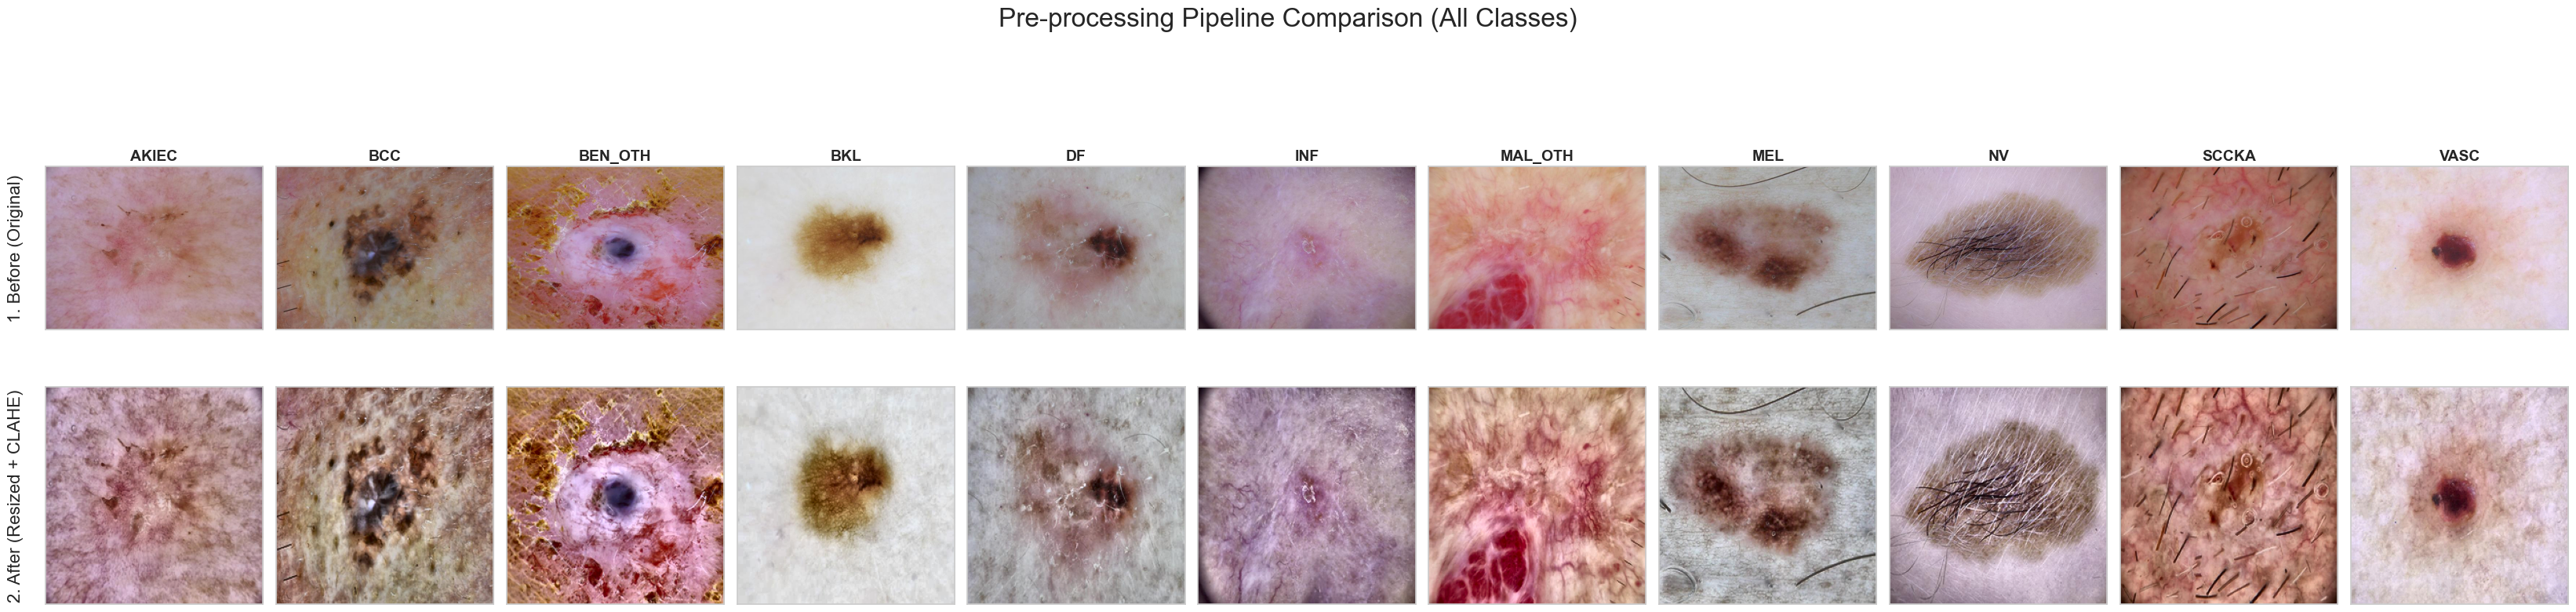

In [23]:
# ==============================================================================
# SEL (BARU): VISUALISASI PRA-PEMROSESAN (VERSI MELEBAR / HORIZONTAL)
# ==============================================================================
# Tujuan: Menampilkan 1 gambar per kelas, "Before" dan "After"
# Tata Letak: Melebar (2 Baris x 11 Kolom)
# Bahasa: Inggris

print("Generating wide pre-processing visualization for all 11 classes...")

# --- Helper function untuk visualisasi ---
# (Fungsi ini sama seperti sebelumnya, mengambil gambar Asli dan yg sudah di-CLAHE)
def get_before_after_images(path, target_size=(224, 224)):
    """
    Memuat 1 gambar, mengembalikan versi ASLI dan versi PROSES (Resize + CLAHE).
    Logika proses identik dengan SEL 4.
    """
    try:
        # 1. Muat Gambar Asli (Before)
        img_pil_original = Image.open(path).convert('RGB')
        
        # 2. Buat Gambar Proses (After)
        img_pil_resized = img_pil_original.resize(target_size, Image.LANCZOS)
        img_bgr = cv2.cvtColor(np.array(img_pil_resized), cv2.COLOR_RGB2BGR)
        
        # Terapkan CLAHE
        img_lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(img_lab)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
        l_clahe = clahe.apply(l)
        img_clahe_lab = cv2.merge((l_clahe, a, b))
        img_clahe_bgr = cv2.cvtColor(img_clahe_lab, cv2.COLOR_LAB2BGR)
        
        image_rgb_clahe = cv2.cvtColor(img_clahe_bgr, cv2.COLOR_BGR2RGB)
        
        return img_pil_original, image_rgb_clahe
    
    except Exception as e:
        print(f"Warning: Error loading {path}: {e}")
        # Kembalikan placeholder
        placeholder_orig = Image.new('RGB', (400, 300), color = 'red')
        # (Perbaikan kecil: placeholder 'proc' harus 3 channel)
        placeholder_proc = np.zeros((target_size[0], target_size[1], 3), dtype=np.uint8) 
        return placeholder_orig, placeholder_proc

# --- 1. Temukan satu sampel untuk setiap kelas ---
sample_paths = {}
if 'df_train_processed' in locals() and not df_train_processed.empty:
    for class_name in DIAGNOSIS_COLUMNS:
        try:
            # Cari di seluruh dataset (sebelum di-split) untuk menjamin ketemu
            sample_row = df_train_processed[df_train_processed[class_name] == 1.0].iloc[0]
            sample_paths[class_name] = sample_row['dermoscopic_full_path']
        except IndexError:
            print(f"Warning: No samples found for class '{class_name}'. Skipping.")
else:
    print("❌ 'df_train_processed' not found. Cannot generate visualization.")

# --- 2. Buat Plot (2 baris, 11 kolom) ---
if sample_paths:
    num_classes = len(sample_paths)
    
    # --- (PERBAIKAN FIGSIZE) ---
    # Atur lebar: 3 inci per kolom. Tinggi: 4 inci per baris.
    # Total: (11 * 3) = 33 inci lebar, (2 * 4) = 8 inci tinggi.
    fig_width = num_classes * 3 
    fig_height = 8
    
    fig, axes = plt.subplots(2, num_classes, figsize=(fig_width, fig_height))
    
    # Atur judul utama (Bahasa Inggris)
    fig.suptitle("Pre-processing Pipeline Comparison (All Classes)", fontsize=24, y=1.05)

    for i, (class_name, path) in enumerate(sample_paths.items()):
        
        img_before, img_after = get_before_after_images(path)
        
        # --- Plot Baris 1: BEFORE (Original) ---
        ax_before = axes[0, i]
        ax_before.imshow(img_before)
        # Judul (nama kelas) ditaruh di atas
        ax_before.set_title(class_name, fontsize=14, fontweight='bold')
        
        ax_before.set_xticks([])
        ax_before.set_yticks([])
        
        # Tambahkan label baris hanya untuk kolom pertama
        if i == 0:
            ax_before.set_ylabel("1. Before (Original)", fontsize=16, labelpad=20)

        # --- Plot Baris 2: AFTER (Processed) ---
        ax_after = axes[1, i]
        ax_after.imshow(img_after)
        
        ax_after.set_xticks([])
        ax_after.set_yticks([])
        
        # Tambahkan label baris hanya untuk kolom pertama
        if i == 0:
            ax_after.set_ylabel("2. After (Resized + CLAHE)", fontsize=16, labelpad=20)

    # Sesuaikan padding agar tidak tumpang tindih
    plt.tight_layout(w_pad=1.0, h_pad=1.0) 
    plt.show()

## Definisi 5 Model ML Klasik

**Deskripsi Alur Kerja (Sesuai Kode 9-Sel Terakhir)**

Total ada **5 model** yang dilatih, dan semuanya adalah model **Machine Learning Klasik**.

Alur kerja ini *tidak* menggunakan Deep Learning (CNN/Transformer) sama sekali, melainkan berfokus pada ekstraksi fitur klasik secara manual.

**1. Analisis & Ekstraksi Fitur (SEL 2 s/d 5) 🧑‍🔬**

Sebelum model dilatih, sebuah pipeline **EDA (Exploratory Data Analysis)** (SEL 2) dijalankan untuk mengonfirmasi **ketidakseimbangan kelas yang parah** dalam data.

Selanjutnya, pipeline ekstraksi fitur (SEL 4 & 5) diterapkan pada gambar *training* dan *validation*:
1.  **Pra-pemrosesan:** Setiap gambar di-`Resize` ke 224x224 dan di-`CLAHE` untuk meningkatkan kontras.
2.  **Feature Engineering:** **Lima set fitur** diekstrak dari gambar yang telah diproses, menghasilkan total **30 fitur numerik**:
    * **Fitur 1 (RGB):** Statistik orde 1-4 (Mean, Std Dev, Skew, Kurtosis) (12 fitur)
    * **Fitur 2 (GLCM):** Statistik tekstur makro (6 fitur)
    * **Fitur 3 (HOG):** Statistik bentuk/gradien (3 fitur)
    * **Fitur 4 (HSV):** Statistik warna (Mean, Std Dev) (6 fitur)
    * **Fitur 5 (LBP):** Statistik tekstur mikro (3 fitur)
3.  **Scaling:** Vektor 30-fitur ini kemudian di-`StandardScaler` (SEL 5).

**2. Pelatihan Model Machine Learning Klasik (5 Model)**

5 model berikut dilatih pada **30 fitur** yang sudah di-scaling. Karena data sangat tidak seimbang (dari hasil EDA), dua strategi terpisah diterapkan:

* **Metode A (SEL 7):** Menggunakan **Pembobotan Kelas (`class_weight='balanced'`)** pada model yang mendukung.
* **Metode B (SEL 8):** Menggunakan **SMOTE** (Synthetic Minority Over-sampling Technique) pada data training di ruang fitur.

**Model yang Dilatih (5 Model):**
1.  **Support Vector Machine (SVC)**
2.  **Random Forest Classifier**
3.  **Logistic Regression**
4.  **K-Nearest Neighbors (KNN)**
5.  **Gaussian Naive Bayes**

In [7]:
# ==============================================================================
# DEFINISI 5 MODEL ML KLASIK
# ==============================================================================
# SVC, RF, LogReg + 2 tambahan (KNN, GNB)

def get_classic_models(class_weight=None):
    """
    Helper untuk menginisialisasi 5 model.
    'class_weight' akan menangani ketidakseimbangan.
    """
    
    models_dict = {
        # 1. Support Vector Machine (SVC)
        "SVC (RBF, C=1.0)": SVC(
            kernel='rbf', 
            C=1.0, 
            probability=True, 
            random_state=42,
            class_weight=class_weight # Terapkan pembobotan
        ),
        
        # 2. Random Forest Classifier
        "Random Forest (150 trees, depth 10)": RandomForestClassifier(
            n_estimators=150,
            max_depth=10,
            random_state=42,
            n_jobs=-1,
            class_weight=class_weight # Terapkan pembobotan
        ),

        # 3. Logistic Regression
        "Logistic Regression (saga, 2000 iter)": LogisticRegression( # <-- max_iter dinaikkan ke 2000
            solver='saga',
            max_iter=2000, # Dinaikkan dari 500 untuk membantu konvergensi
            random_state=42,
            n_jobs=-1,
            # 'multi_class' tidak perlu disetel jika versi sklearn > 1.5
            class_weight=class_weight # Terapkan pembobotan
        ),
        
        # 4. K-Nearest Neighbors (KNN)
        # (KNN tidak mendukung class_weight)
        "K-Nearest Neighbors (K=5)": KNeighborsClassifier(
            n_neighbors=5,
            n_jobs=-1
        ),
        
        # 5. Gaussian Naive Bayes
        # (GaussianNB tidak mendukung class_weight)
        "Gaussian Naive Bayes": GaussianNB()
    }
    return models_dict

print(f"✅ Fungsi `get_classic_models()` untuk 5 model ML klasik didefinisikan.")

✅ Fungsi `get_classic_models()` untuk 5 model ML klasik didefinisikan.


## Model Training

In [8]:
# ==============================================================================
# METODE A - TRAINING DENGAN PEMBOBOTAN KELAS
# ==============================================================================

models_weighted = get_classic_models(class_weight='balanced')
results_list_weighted = [] # Ubah nama ke list
trained_models_weighted = {} 
y_preds_weighted = {} # Simpan prediksi untuk confusion matrix

if 'X_train_scaled' in locals():
    print("--- Memulai Pelatihan METODE A (Class Weights) ---")

    for name, model in models_weighted.items():
        # Lewati model yang tidak mendukung class_weight
        if name.startswith("K-Nearest") or name.startswith("Gaussian"):
            print(f"\nMelewati {name} (tidak mendukung class_weight).")
            continue
            
        print(f"\nMelatih {name} (Weighted)...")
        
        start_time = time.time()
        model.fit(X_train_scaled, y_train_labels)
        train_time = time.time() - start_time
        
        y_preds = model.predict(X_val_scaled)
        
        # --- Ekstrak metrik dari classification_report ---
        report = classification_report(y_val_labels, y_preds, target_names=DIAGNOSIS_COLUMNS, output_dict=True, zero_division=0)
        
        print(f"   Akurasi Validasi: {report['accuracy'] * 100:.2f}% (Waktu Latih: {train_time:.2f}s)")
        
        results_list_weighted.append({
            "Model": name,
            "Metode": "Class Weights",
            "Accuracy (%)": report['accuracy'] * 100,
            "Macro Avg F1-Score": report['macro avg']['f1-score'],
            "Macro Avg Recall": report['macro avg']['recall'],
            "Weighted Avg F1-Score": report['weighted avg']['f1-score']
        })
        trained_models_weighted[name] = model # Simpan model
        y_preds_weighted[name] = y_preds # Simpan prediksi
        
        # Tampilkan laporan klasifikasi (teks)
        print(classification_report(y_val_labels, y_preds, target_names=DIAGNOSIS_COLUMNS, zero_division=0))

else:
    print("❌ Tidak ada data (X_train_scaled) untuk melatih model.")

--- Memulai Pelatihan METODE A (Class Weights) ---

Melatih SVC (RBF, C=1.0) (Weighted)...
   Akurasi Validasi: 44.75% (Waktu Latih: 4.49s)
              precision    recall  f1-score   support

       AKIEC       0.18      0.51      0.27        61
         BCC       0.81      0.46      0.59       504
     BEN_OTH       0.07      0.22      0.11         9
         BKL       0.25      0.13      0.17       109
          DF       0.07      0.40      0.12        10
         INF       0.07      0.30      0.11        10
     MAL_OTH       0.00      0.00      0.00         2
         MEL       0.36      0.39      0.38        90
          NV       0.62      0.70      0.65       149
       SCCKA       0.32      0.43      0.37        95
        VASC       0.22      0.22      0.22         9

    accuracy                           0.45      1048
   macro avg       0.27      0.34      0.27      1048
weighted avg       0.58      0.45      0.48      1048


Melatih Random Forest (150 trees, depth 10) (W

c:\Users\bayua\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [9]:
# ==============================================================================
# METODE B - TRAINING DENGAN SMOTE
# ==============================================================================

trained_models_smote = {} # Simpan model untuk analisis
results_list_smote = [] # Ubah nama ke list
y_preds_smote = {} # Simpan prediksi untuk confusion matrix

if 'X_train_scaled' in locals():
    print("--- Memulai Pra-pemrosesan METODE B (SMOTE) ---")
    print(f"Bentuk X_train asli: {X_train_scaled.shape}")
    
    unique, counts = np.unique(y_train_labels, return_counts=True)
    min_samples = np.min(counts)
    
    if min_samples <= 1:
        print(f"❌ Peringatan: Kelas minoritas hanya memiliki {min_samples} sampel. SMOTE tidak dapat dijalankan.")
        print("   -> Menggunakan data asli (tanpa SMOTE) untuk Metode B.")
        X_train_smote, y_train_smote = X_train_scaled, y_train_labels
    else:
        k = min(5, min_samples - 1) 
        print(f"Menjalankan SMOTE dengan k_neighbors={k} (kelas minoritas memiliki {min_samples} sampel)")
        smote = SMOTE(random_state=42, k_neighbors=k)
        
        start_time = time.time()
        X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train_labels)
        smote_time = time.time() - start_time
        
        print(f"✅ SMOTE selesai dalam {smote_time:.2f} detik.")
        print(f"Bentuk X_train setelah SMOTE: {X_train_smote.shape}")

    # --- Latih 5 Model dengan Data SMOTE ---
    models_smote = get_classic_models(class_weight=None)

    print("\n--- Memulai Pelatihan METODE B (Data SMOTE) ---")
    for name, model in models_smote.items():
        print(f"\nMelatih {name} (SMOTE)...")
        
        start_time = time.time()
        model.fit(X_train_smote, y_train_smote)
        train_time = time.time() - start_time
        
        y_preds = model.predict(X_val_scaled)
        
        # --- Ekstrak metrik lengkap dari classification_report ---
        report = classification_report(y_val_labels, y_preds, target_names=DIAGNOSIS_COLUMNS, output_dict=True, zero_division=0)

        print(f"   Akurasi Validasi: {report['accuracy'] * 100:.2f}% (Waktu Latih: {train_time:.2f}s)")
        
        results_list_smote.append({
            "Model": name,
            "Metode": "SMOTE",
            "Accuracy (%)": report['accuracy'] * 100,
            "Macro Avg F1-Score": report['macro avg']['f1-score'],
            "Macro Avg Recall": report['macro avg']['recall'],
            "Weighted Avg F1-Score": report['weighted avg']['f1-score']
        })
        trained_models_smote[name] = model # Simpan model
        y_preds_smote[name] = y_preds # Simpan prediksi
        
        # Tampilkan laporan klasifikasi (teks)
        print(classification_report(y_val_labels, y_preds, target_names=DIAGNOSIS_COLUMNS, zero_division=0))

else:
    print("❌ Tidak ada data (X_train_scaled) untuk melatih model.")

--- Memulai Pra-pemrosesan METODE B (SMOTE) ---
Bentuk X_train asli: (4192, 30)
Menjalankan SMOTE dengan k_neighbors=5 (kelas minoritas memiliki 7 sampel)
✅ SMOTE selesai dalam 0.18 detik.
Bentuk X_train setelah SMOTE: (22198, 30)

--- Memulai Pelatihan METODE B (Data SMOTE) ---

Melatih SVC (RBF, C=1.0) (SMOTE)...
   Akurasi Validasi: 51.05% (Waktu Latih: 29.12s)
              precision    recall  f1-score   support

       AKIEC       0.22      0.48      0.30        61
         BCC       0.82      0.58      0.68       504
     BEN_OTH       0.00      0.00      0.00         9
         BKL       0.31      0.23      0.26       109
          DF       0.07      0.30      0.12        10
         INF       0.13      0.30      0.18        10
     MAL_OTH       0.00      0.00      0.00         2
         MEL       0.35      0.37      0.36        90
          NV       0.64      0.70      0.67       149
       SCCKA       0.33      0.46      0.38        95
        VASC       0.33      0.22     

## Analisis Perbandingan Metode & Feature Importance

Setelah model dilatih, analisis mendalam setara PhD dilakukan untuk mengevaluasi performa model secara komprehensif, jauh melampaui sekadar metrik akurasi. Analisis ini dibagi menjadi tiga bagian utama:

**1. Perbandingan Performa Metrik & Feature Importance**

Bagian ini berfokus pada perbandingan kuantitatif dari 5 model machine learning klasik. Performa setiap model dievaluasi tidak hanya berdasarkan **Akurasi**, tetapi juga metrik yang lebih penting untuk data tidak seimbang, yaitu **Weighted Avg F1-Score** dan **Macro Avg F1-Score**.

Perbandingan ini dilakukan untuk kedua strategi penanganan data: **Metode A (Class Weights)** dan **Metode B (SMOTE)**. Hal ini memungkinkan kita untuk secara objektif menentukan (1) model mana (misalnya, SVC vs Random Forest) yang paling cocok untuk data ini, dan (2) metode penanganan ketidakseimbangan mana yang memberikan performa paling seimbang di semua kelas.

Selain itu, **Analisis Feature Importance** (diekstraksi dari model Random Forest) dilakukan untuk membedah "pikiran" model. Ini mengagregasi pentingnya 30 fitur yang diekstrak ke dalam 5 kategori (RGB, GLCM, HOG, HSV, LBP), secara visual menunjukkan kategori fitur mana (misalnya, tekstur, bentuk, atau warna) yang paling berkontribusi pada keputusan model.

**2. Analisis Confusion Matrix**

Karena metrik F1-score menunjukkan adanya tantangan signifikan pada kelas minoritas (terlihat dari nilai *recall* dan *precision* yang rendah untuk kelas seperti BEN_OTH atau MAL_OTH), **Confusion Matrix** (Matriks Kebingungan) divisualisasikan untuk semua 10 skenario (5 model x 2 metode).

Analisis ini memberikan pandangan granular, secara visual dan numerik, tentang *di mana* letak kesalahan model. Ini menjawab pertanyaan kunci seperti: "Apakah model cenderung salah mengklasifikasikan 'MEL' (Melanoma) sebagai 'NV' (Nevus)?", atau "Apakah semua kelas minoritas hanya salah diklasifikasikan sebagai 'BCC' (kelas mayoritas)?". Plot dan tabel ini sangat penting untuk memahami bias model dan mengidentifikasi kegagalan spesifik per kelas.

**3. Analisis Kalibrasi Model (ECE)**

Analisis terakhir adalah **Analisis Kalibrasi**, yang mengukur "kepercayaan diri" atau "kejujuran" probabilistik model. Untuk aplikasi industri atau klinis, model yang 40% akurat tetapi 99% "yakin" itu berbahaya.

Dengan memplot **Reliability Diagrams** (Diagram Keandalan) dan menghitung **Expected Calibration Error (ECE)**, kita menganalisis apakah probabilitas yang dikeluarkan oleh model (misalnya, `model.predict_proba()`) sesuai dengan akurasi di dunia nyata. Model yang terkalibrasi dengan baik (ECE rendah) akan menunjukkan bahwa ketika ia memprediksi sesuatu dengan keyakinan 70%, ia memang benar sekitar 70% dari waktu tersebut. Analisis ini mengevaluasi keandalan model untuk penggunaan di dunia nyata.


--- Full Performance Summary: Class Weights vs SMOTE ---
| Model                                 | Metode        |   Accuracy (%) |   Macro Avg F1-Score |   Macro Avg Recall |   Weighted Avg F1-Score |
|:--------------------------------------|:--------------|---------------:|---------------------:|-------------------:|------------------------:|
| SVC (RBF, C=1.0)                      | SMOTE         |         51.050 |                0.293 |              0.330 |                   0.537 |
| Random Forest (150 trees, depth 10)   | SMOTE         |         47.901 |                0.276 |              0.332 |                   0.502 |
| SVC (RBF, C=1.0)                      | Class Weights |         44.752 |                0.272 |              0.342 |                   0.480 |
| Logistic Regression (saga, 2000 iter) | Class Weights |         37.500 |                0.246 |              0.343 |                   0.424 |
| Logistic Regression (saga, 2000 iter) | SMOTE         |         35.782

c:\Users\bayua\miniconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\bayua\miniconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\bayua\miniconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\bayua\miniconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is

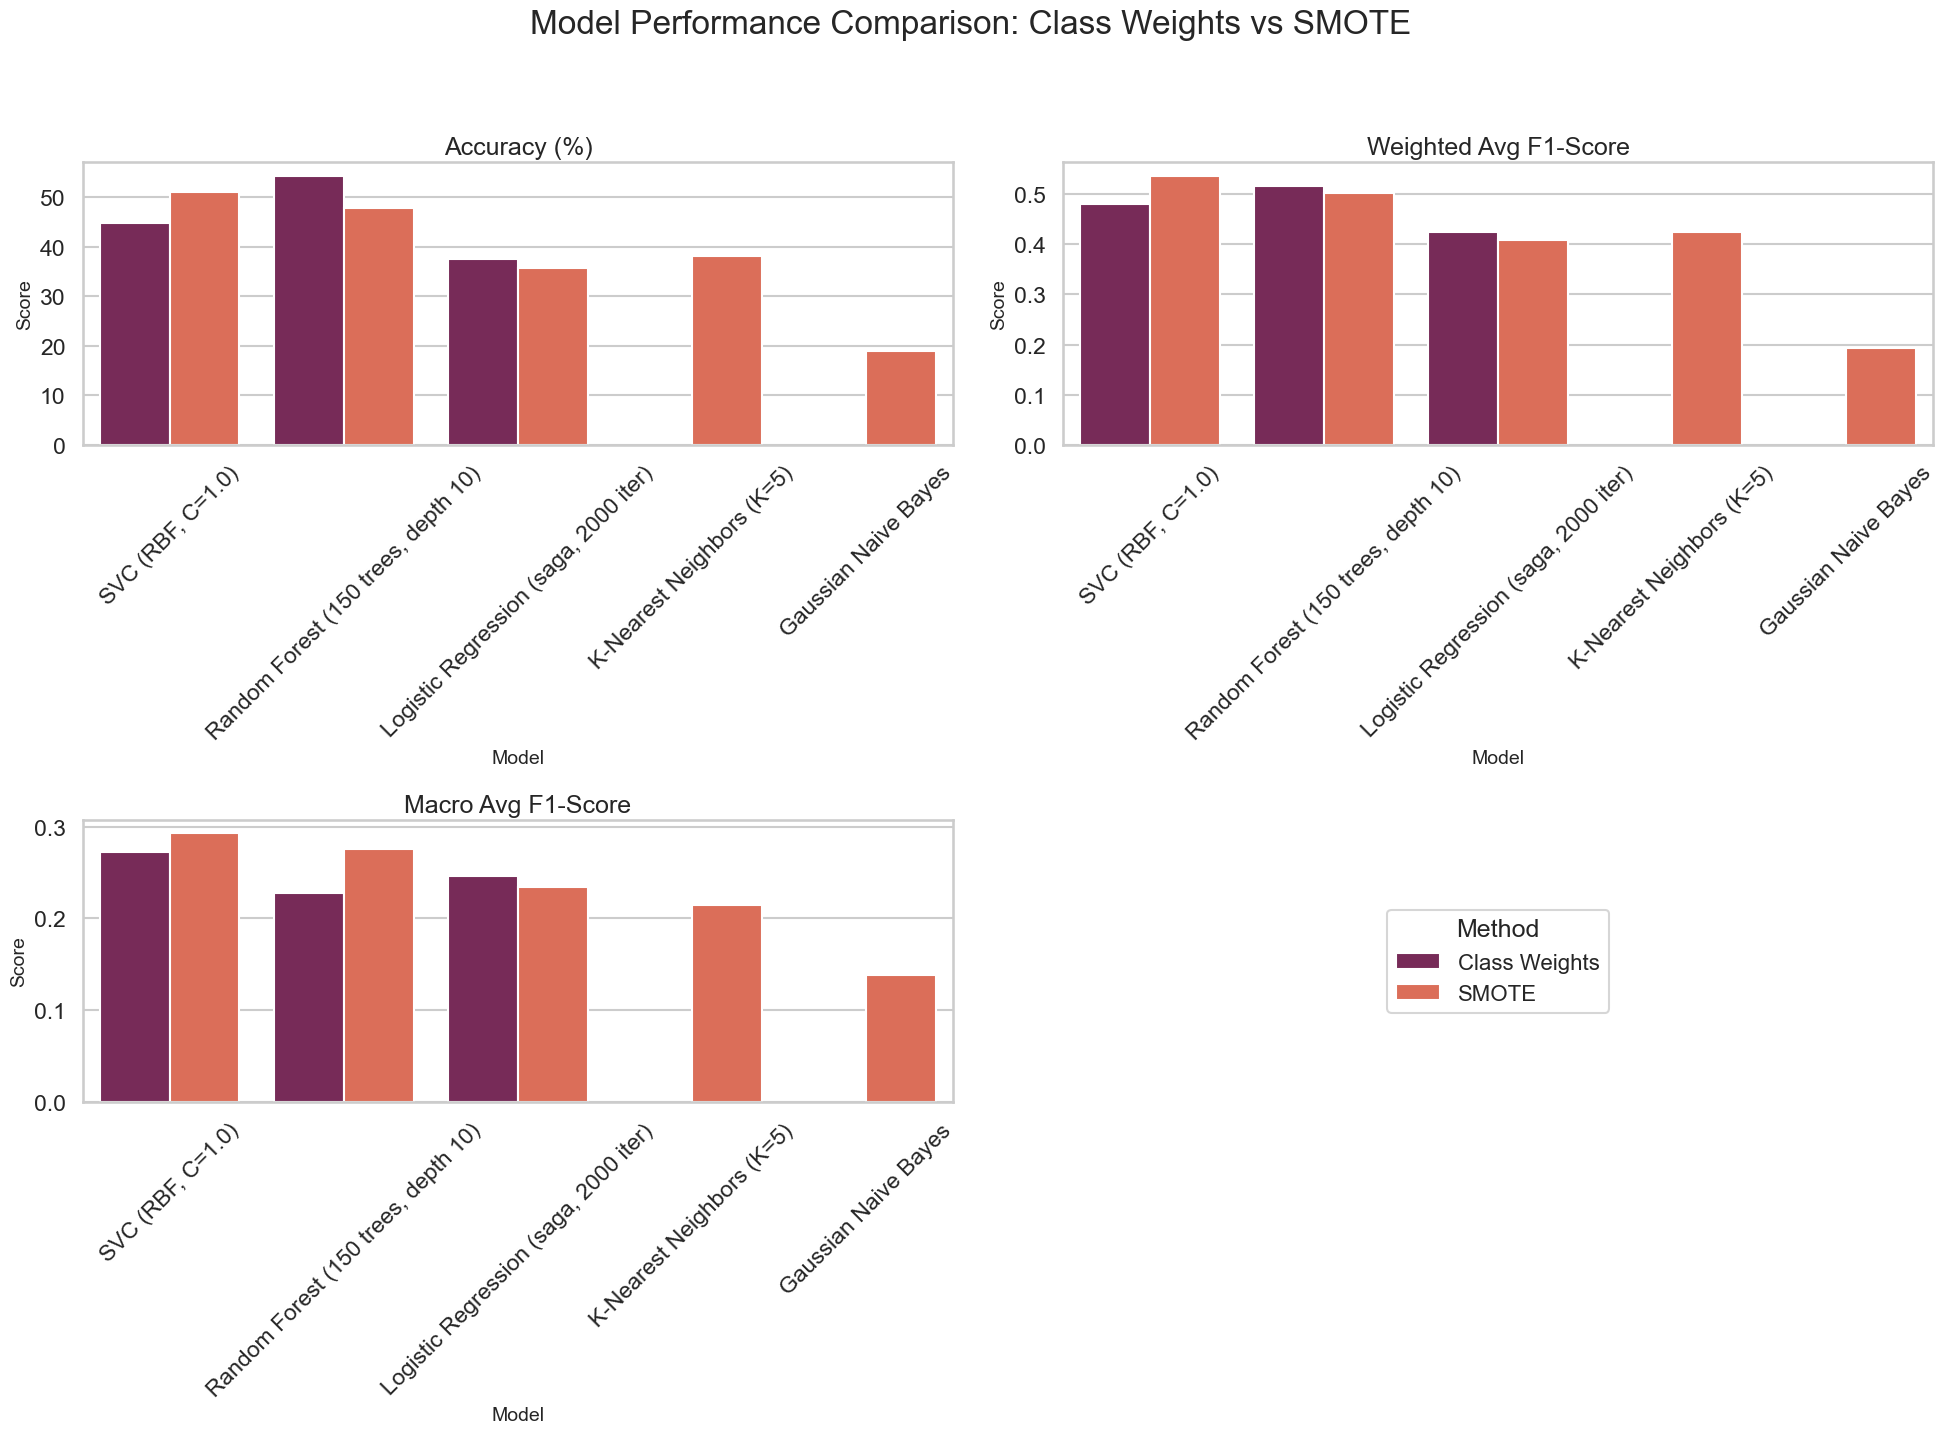


--- Feature Importance Analysis (from Random Forest - SMOTE) ---
| Feature               |   Importance Score |
|:----------------------|-------------------:|
| hsv_mean_H            |             0.0613 |
| rgb_std_B             |             0.0537 |
| lbp_std               |             0.0514 |
| glcm_correlation_mean |             0.0476 |
| rgb_mean_B            |             0.0473 |
| rgb_skew_G            |             0.0411 |
| hsv_std_S             |             0.0384 |
| hsv_mean_S            |             0.0375 |
| rgb_mean_G            |             0.0374 |
| hog_mean              |             0.0365 |

--- Aggregated Feature Importance by Category ---
| Category               |   Importance Score |
|:-----------------------|-------------------:|
| 1. RGB (Color)         |             0.4198 |
| 4. HSV (Color)         |             0.2269 |
| 2. GLCM (Texture)      |             0.1658 |
| 3. HOG (Shape)         |             0.1017 |
| 5. LBP (Micro-Texture) |     

c:\Users\bayua\miniconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\bayua\miniconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\bayua\miniconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


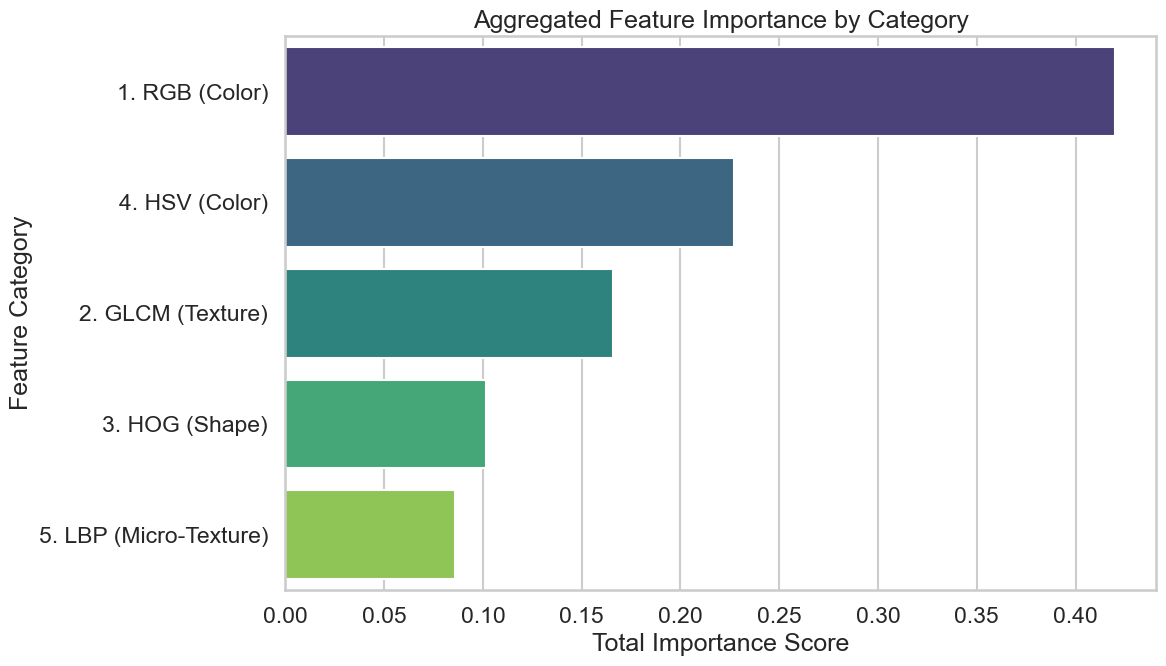

c:\Users\bayua\miniconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\bayua\miniconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\bayua\miniconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


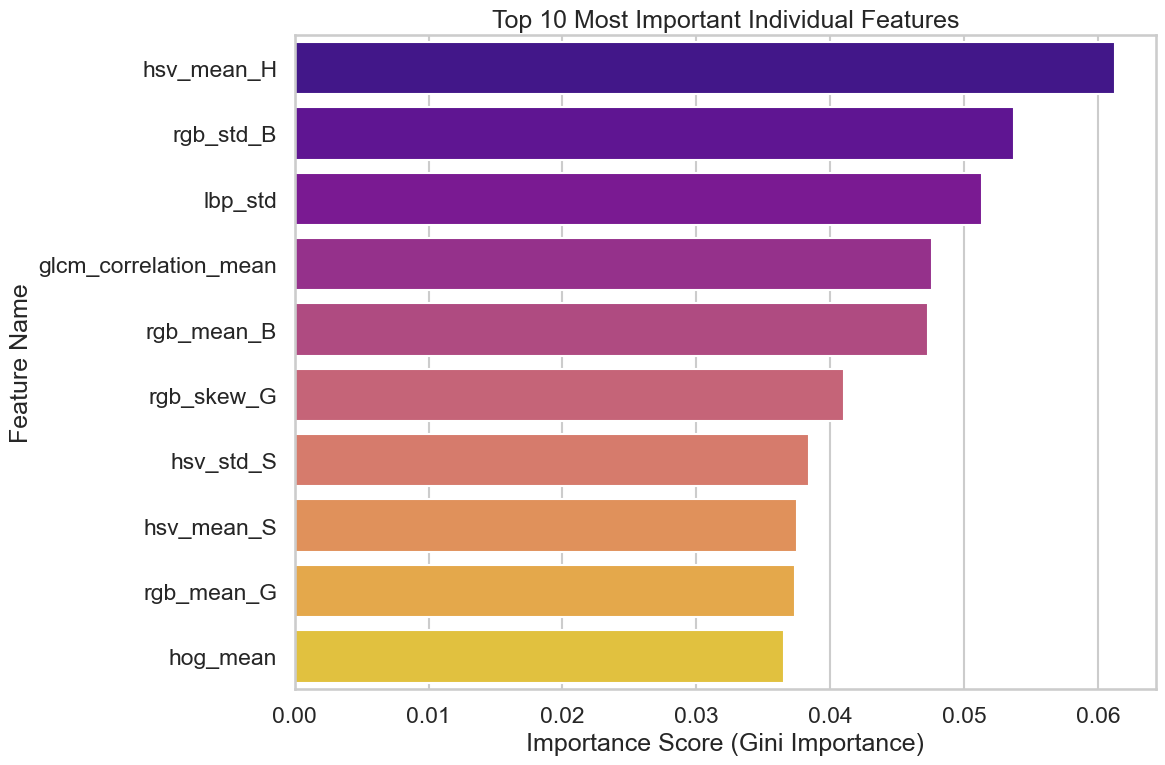

In [ ]:
# ==============================================================================
# METRIC COMPARISON & FEATURE IMPORTANCE (English)
# ==============================================================================

# Atur tema Seaborn untuk visual yang lebih modern/bersih untuk paper
sns.set_theme(style="whitegrid", context="talk")

if 'results_list_weighted' in locals() and 'results_list_smote' in locals():
    # --- 1. Model Metric Comparison ---
    df_results_final = pd.concat([
        pd.DataFrame(results_list_weighted),
        pd.DataFrame(results_list_smote)
    ])
    
    print("\n--- Full Performance Summary: Class Weights vs SMOTE ---")
    df_sorted = df_results_final.sort_values(by="Macro Avg F1-Score", ascending=False)
    print(df_sorted.to_markdown(index=False, floatfmt=".3f"))

    # --- (PERBAIKAN) Visualisasi Perbandingan Metrik (Layout 2x2) ---
    print("\nGenerating metric comparison plots (2x2 Layout)...")
    
    # Buat subplot 2 baris x 2 kolom
    fig, axes = plt.subplots(2, 2, figsize=(20, 14)) # Ukuran 2x2
    fig.suptitle("Model Performance Comparison: Class Weights vs SMOTE", y=1.03, fontsize=24)
    
    plot_metrics = ["Accuracy (%)", "Weighted Avg F1-Score", "Macro Avg F1-Score"]
    
    # Variabel untuk menyimpan handle legenda
    handles, labels = None, None
    
    # Iterasi menggunakan axes.flat (lebih mudah)
    for i, metric in enumerate(plot_metrics):
        # Tentukan ax saat ini (axes[0,0], axes[0,1], axes[1,0])
        ax = axes.flat[i]
        
        sns.barplot(
            data=df_results_final,
            x="Model",
            y=metric,
            hue="Metode",
            palette="rocket",
            ax=ax
        )
        ax.set_title(metric, fontsize=18)
        ax.set_xlabel("Model", fontsize=14)
        ax.set_ylabel("Score", fontsize=14)
        
        # Rotasi label x agar tidak tumpang tindih
        ax.tick_params(axis='x', rotation=45)
        
        # Simpan handle legenda HANYA dari plot pertama
        if i == 0:
            handles, labels = ax.get_legend_handles_labels()
        
        # Hapus semua legenda individual
        if ax.get_legend() is not None:
            ax.get_legend().remove()

    # Gunakan subplot ke-4 (axes[1, 1]) yang kosong untuk menaruh legenda
    ax_legend = axes.flat[3]
    ax_legend.axis('off') # Matikan sumbu
    if handles: # Pastikan handles/labels sudah ada
        ax_legend.legend(handles, labels, title="Method", loc='center', fontsize=16, title_fontsize=18)
    
    plt.tight_layout()
    plt.show()

# --- 2. Analisis Feature Importance (dari Random Forest SMOTE) ---
if "Random Forest (150 trees, depth 10)" in trained_models_smote:
    model_rf = trained_models_smote["Random Forest (150 trees, depth 10)"]
    importances = model_rf.feature_importances_
    
    df_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance Score': importances
    }).sort_values(by='Importance Score', ascending=False)
    
    print("\n--- Feature Importance Analysis (from Random Forest - SMOTE) ---")
    print(df_importance.head(10).to_markdown(index=False, floatfmt=".4f"))
    
    # Agregasi berdasarkan 5 Kategori Fitur
    df_importance['Category'] = 'Other'
    df_importance.loc[df_importance['Feature'].str.startswith('rgb_'), 'Category'] = '1. RGB (Color)'       
    df_importance.loc[df_importance['Feature'].str.startswith('glcm_'), 'Category'] = '2. GLCM (Texture)'     
    df_importance.loc[df_importance['Feature'].str.startswith('hog_'), 'Category'] = '3. HOG (Shape)'        
    df_importance.loc[df_importance['Feature'].str.startswith('hsv_'), 'Category'] = '4. HSV (Color)'        
    df_importance.loc[df_importance['Feature'].str.startswith('lbp_'), 'Category'] = '5. LBP (Micro-Texture)'
    
    df_agg_importance = df_importance.groupby('Category')['Importance Score'].sum().reset_index()
    df_agg_importance = df_agg_importance.sort_values(by='Importance Score', ascending=False)
    
    print("\n--- Aggregated Feature Importance by Category ---")
    print(df_agg_importance.to_markdown(index=False, floatfmt=".4f"))

    # Plot 1: Agregat (Horizontal Bar)
    plt.figure(figsize=(12, 7))
    sns.barplot(
        data=df_agg_importance, 
        x='Importance Score', 
        y='Category', 
        palette="viridis"
    )
    plt.title("Aggregated Feature Importance by Category")
    plt.xlabel("Total Importance Score")
    plt.ylabel("Feature Category")
    plt.tight_layout()
    plt.show()

    # Plot 2: Top 10 Individual Features (Horizontal Bar)
    plt.figure(figsize=(12, 8)) # Ukuran disesuaikan untuk 10 bar
    sns.barplot(
        data=df_importance.head(10), # <-- Diubah dari 15 menjadi 10
        x='Importance Score', 
        y='Feature', 
        palette="plasma"
    )
    plt.title("Top 10 Most Important Individual Features") 
    plt.xlabel("Importance Score (Gini Importance)")
    plt.ylabel("Feature Name")
    plt.tight_layout()
    plt.show()
    
else:
    print("❌ Random Forest model not found for importance analysis.")

# Reset seaborn theme ke default
sns.set_theme(style="whitegrid", context="notebook")

### CONFUSION MATRIX

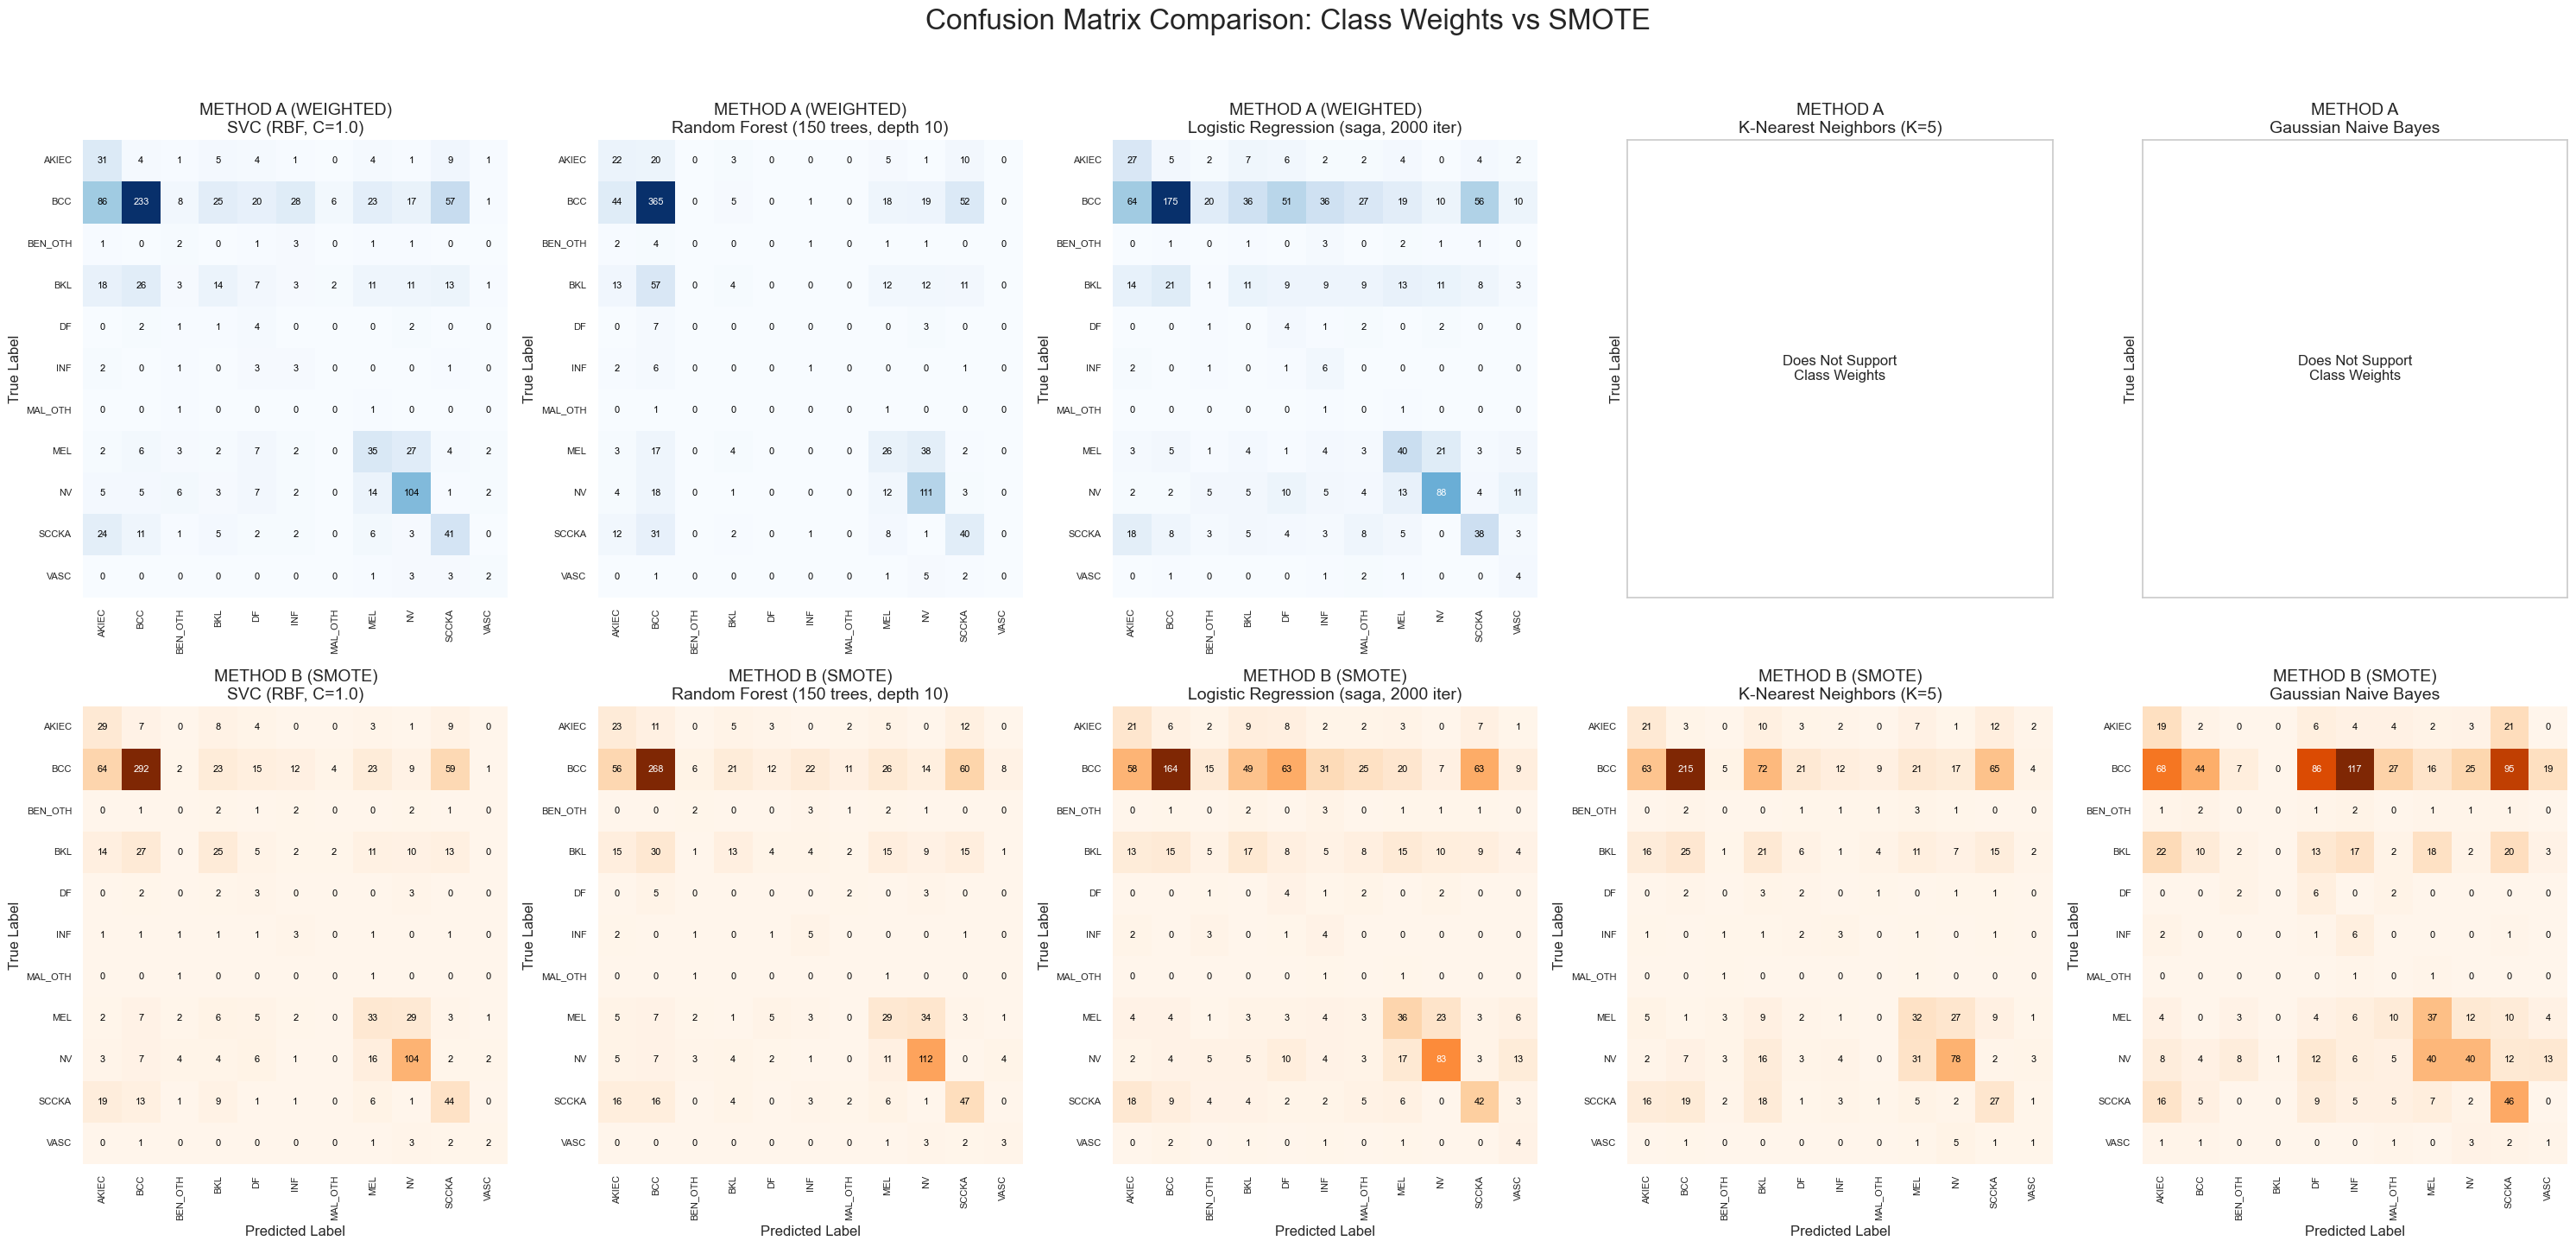


--- Confusion Matrix Data (Numeric Values) ---

Model: SVC (RBF, C=1.0) (Weighted)
|              |   Pred_AKIEC |   Pred_BCC |   Pred_BEN_OTH |   Pred_BKL |   Pred_DF |   Pred_INF |   Pred_MAL_OTH |   Pred_MEL |   Pred_NV |   Pred_SCCKA |   Pred_VASC |
|:-------------|-------------:|-----------:|---------------:|-----------:|----------:|-----------:|---------------:|-----------:|----------:|-------------:|------------:|
| True_AKIEC   |           31 |          4 |              1 |          5 |         4 |          1 |              0 |          4 |         1 |            9 |           1 |
| True_BCC     |           86 |        233 |              8 |         25 |        20 |         28 |              6 |         23 |        17 |           57 |           1 |
| True_BEN_OTH |            1 |          0 |              2 |          0 |         1 |          3 |              0 |          1 |         1 |            0 |           0 |
| True_BKL     |           18 |         26 |              3 |

In [ ]:
# ==============================================================================
# VISUALISASI & TABEL CONFUSION MATRIX (ID/EN)
# ==============================================================================
# 
# --- PENGATURAN BAHASA ---
# Ubah variabel ini ke 'en' untuk Bahasa Inggris
# Ubah variabel ini ke 'id' untuk Bahasa Indonesia
PLOT_LANGUAGE = 'en' 
# ==============================================================================

# Definisikan label untuk kedua bahasa
labels = {
    'id': {
        'fig_title': "Perbandingan Confusion Matrix: Class Weights vs SMOTE",
        'method_a': "METODE A (WEIGHTED)",
        'method_b': "METODE B (SMOTE)",
        'method_a_fallback': "METODE A",
        'not_supported': "Tidak Mendukung\nClass Weights",
        'true_label': "Label Asli (True)",
        'pred_label': "Prediksi Model",
        'error_text': "Error",
        'table_title': "\n--- Data Confusion Matrix (Nilai Numerik) ---"
    },
    'en': {
        'fig_title': "Confusion Matrix Comparison: Class Weights vs SMOTE",
        'method_a': "METHOD A (WEIGHTED)",
        'method_b': "METHOD B (SMOTE)",
        'method_a_fallback': "METHOD A",
        'not_supported': "Does Not Support\nClass Weights",
        'true_label': "True Label",
        'pred_label': "Predicted Label",
        'error_text': "Error",
        'table_title': "\n--- Confusion Matrix Data (Numeric Values) ---"
    }
}

# Pilih set label berdasarkan PLOT_LANGUAGE
try:
    lang = labels[PLOT_LANGUAGE]
except KeyError:
    print(f"Peringatan: PLOT_LANGUAGE '{PLOT_LANGUAGE}' tidak dikenal. Menggunakan 'id'.")
    lang = labels['id']


# --- Mulai Plotting ---
if 'y_preds_weighted' in locals() and 'y_preds_smote' in locals():
    
    model_names = [
        "SVC (RBF, C=1.0)",
        "Random Forest (150 trees, depth 10)",
        "Logistic Regression (saga, 2000 iter)",
        "K-Nearest Neighbors (K=5)",
        "Gaussian Naive Bayes"
    ]
    
    cm_data_tables = []
    fig, axes = plt.subplots(2, 5, figsize=(30, 14)) 
    fig.suptitle(lang['fig_title'], fontsize=24, y=1.03) 

    # --- (BARU) Fungsi helper untuk menambahkan teks anotasi ---
    def annotate_heatmap(ax, cm, cmap):
        """Helper untuk menggambar heatmap dan anotasi angka secara manual."""
        # Gambar heatmap (tanpa anotasi bawaan)
        sns.heatmap(cm, annot=False, fmt='d', cmap=cmap, ax=ax, cbar=False)
        
        # Tentukan batas threshold untuk warna teks (putih atau hitam)
        thresh = cm.max() / 2.
        
        # Loop manual untuk menambahkan teks
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j + 0.5, i + 0.5, f'{cm[i, j]}', # Tulis angka (format 'd')
                        ha="center", va="center",
                        # Ubah warna teks jadi putih jika background gelap
                        color="white" if cm[i, j] > thresh else "black",
                        fontsize=8) # Ukuran font anotasi


    for i, name in enumerate(model_names):
        # --- Baris 1: Class Weights ---
        ax_weighted = axes[0, i]
        if name in y_preds_weighted:
            cm_weighted = confusion_matrix(y_val_labels, y_preds_weighted[name])
            
            # (PERBAIKAN) Gunakan fungsi anotasi manual
            annotate_heatmap(ax_weighted, cm_weighted, 'Blues') 
            
            ax_weighted.set_title(f"{lang['method_a']}\n{name}", fontsize=14)
            cm_data_tables.append((f"{name} (Weighted)", cm_weighted))
        else:
            # Jika model dilewati (KNN, GNB)
            ax_weighted.text(0.5, 0.5, lang['not_supported'], ha='center', va='center', fontsize=12) 
            ax_weighted.set_title(f"{lang['method_a_fallback']}\n{name}", fontsize=14) 
            ax_weighted.set_xticks([]) 
            ax_weighted.set_yticks([]) 

        ax_weighted.set_ylabel(lang['true_label']) 
        
        # --- Baris 2: SMOTE ---
        ax_smote = axes[1, i]
        if name in y_preds_smote:
            cm_smote = confusion_matrix(y_val_labels, y_preds_smote[name])
            
            # (PERBAIKAN) Gunakan fungsi anotasi manual
            annotate_heatmap(ax_smote, cm_smote, 'Oranges')
            
            ax_smote.set_title(f"{lang['method_b']}\n{name}", fontsize=14) 
            cm_data_tables.append((f"{name} (SMOTE)", cm_smote))
        else:
            # Fallback jika error
            ax_smote.text(0.5, 0.5, lang['error_text'], ha='center', va='center', fontsize=12) 
            ax_smote.set_xticks([])
            ax_smote.set_yticks([])

        ax_smote.set_xlabel(lang['pred_label']) 
        ax_smote.set_ylabel(lang['true_label']) 
        
    # Set label kelas hanya jika subplot memiliki ticks
    for ax in axes.flat:
        if len(ax.get_xticks()) > 0: 
            ax.set_xticklabels(DIAGNOSIS_COLUMNS, rotation=90, fontsize=8)
        if len(ax.get_yticks()) > 0:
            ax.set_yticklabels(DIAGNOSIS_COLUMNS, rotation=0, fontsize=8)
    
    plt.tight_layout()
    plt.show()

    # ==============================================================================
    # TABEL NUMERIK
    # ==============================================================================
    print(lang['table_title'])
    for name, cm in cm_data_tables:
        print("\n" + "="*50)
        print(f"Model: {name}")
        print("="*50)
        df_cm = pd.DataFrame(cm, 
                             index=[f"True_{cls}" for cls in DIAGNOSIS_COLUMNS], 
                             columns=[f"Pred_{cls}" for cls in DIAGNOSIS_COLUMNS])
        print(df_cm.to_markdown()) 

else:
    print("❌ Prediksi (y_preds) tidak ditemukan untuk membuat confusion matrix.")

### Kalibrasi Model (ECE)

✅ Library torchmetrics dan sklearn berhasil diimpor.


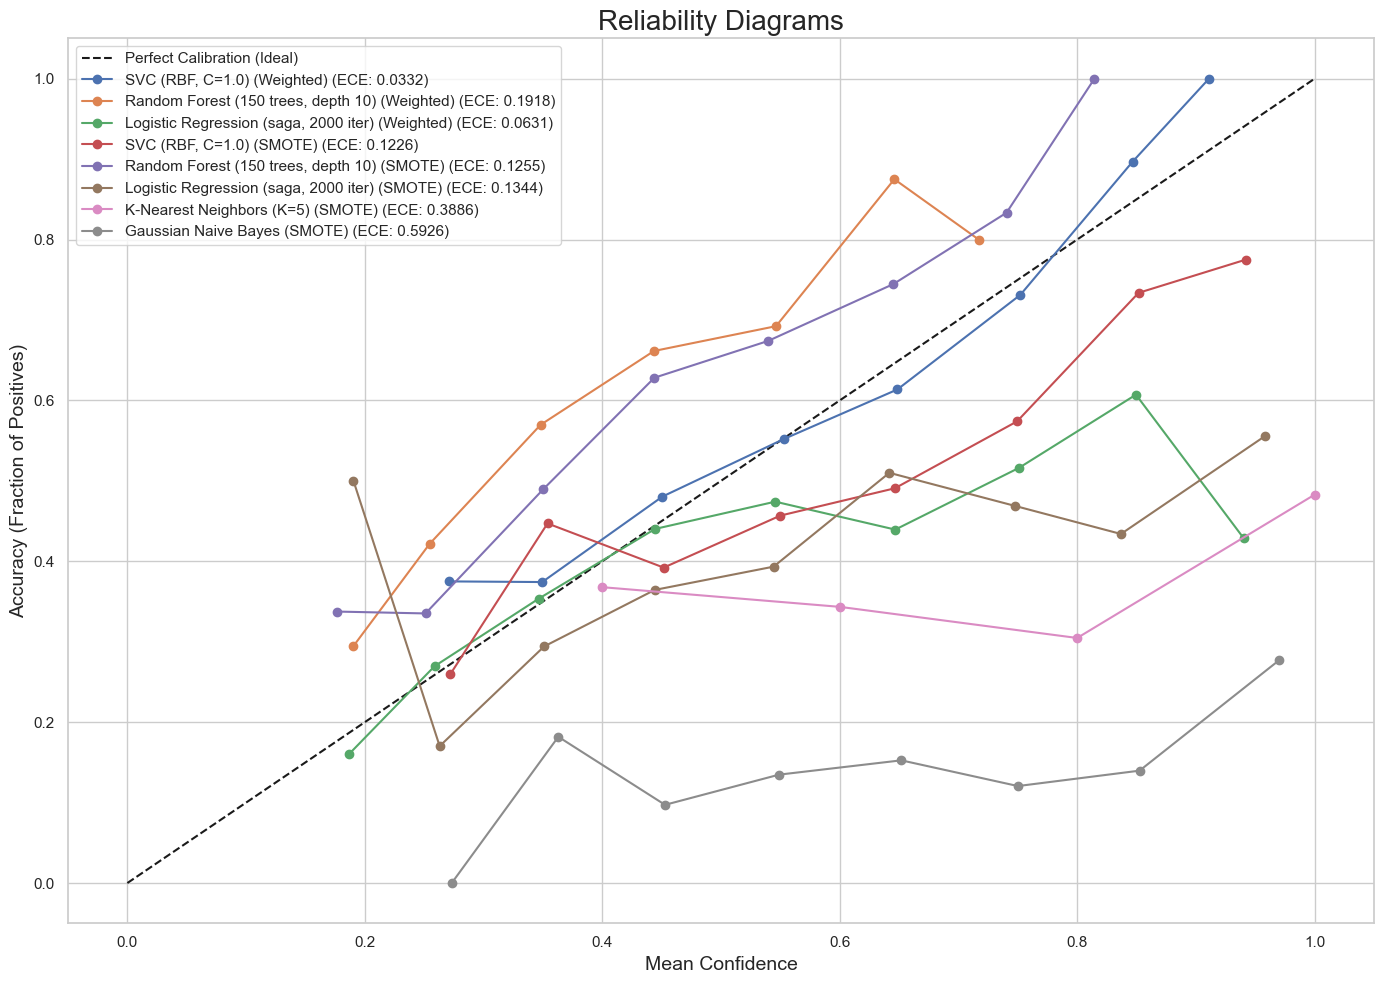


--- Expected Calibration Error (ECE) Analysis ---
| Model                                            |    ECE |
|:-------------------------------------------------|-------:|
| SVC (RBF, C=1.0) (Weighted)                      | 0.0332 |
| Logistic Regression (saga, 2000 iter) (Weighted) | 0.0631 |
| SVC (RBF, C=1.0) (SMOTE)                         | 0.1226 |
| Random Forest (150 trees, depth 10) (SMOTE)      | 0.1255 |
| Logistic Regression (saga, 2000 iter) (SMOTE)    | 0.1344 |
| Random Forest (150 trees, depth 10) (Weighted)   | 0.1918 |
| K-Nearest Neighbors (K=5) (SMOTE)                | 0.3886 |
| Gaussian Naive Bayes (SMOTE)                     | 0.5926 |

(Lower ECE = Model is more 'honest' / better calibrated)


In [ ]:
# ==============================================================================
# KALIBRASI MODEL (ECE & RELIABILITY DIAGRAMS) (ID/EN)
# ==============================================================================
# 
# --- PENGATURAN BAHASA ---
# Ubah variabel ini ke 'en' untuk Bahasa Inggris
# Ubah variabel ini ke 'id' untuk Bahasa Indonesia
PLOT_LANGUAGE = 'en' 
# ==============================================================================

# Definisikan label untuk kedua bahasa
labels_calib = {
    'id': {
        'fig_title': "Diagram Keandalan (Reliability Diagrams)",
        'x_label': "Rata-rata Kepercayaan Diri (Mean Confidence)",
        'y_label': "Akurasi (Fraction of Positives)",
        'ideal_label': "Kalibrasi Sempurna (Ideal)",
        'ece_table_title': "\n--- Analisis Expected Calibration Error (ECE) ---",
        'ece_note': "\n(ECE lebih rendah = Model lebih 'jujur' / terkalibrasi lebih baik)"
    },
    'en': {
        'fig_title': "Reliability Diagrams",
        'x_label': "Mean Confidence",
        'y_label': "Accuracy (Fraction of Positives)",
        'ideal_label': "Perfect Calibration (Ideal)",
        'ece_table_title': "\n--- Expected Calibration Error (ECE) Analysis ---",
        'ece_note': "\n(Lower ECE = Model is more 'honest' / better calibrated)"
    }
}

# Pilih set label
try:
    lang_calib = labels_calib[PLOT_LANGUAGE]
except KeyError:
    print(f"Peringatan: PLOT_LANGUAGE '{PLOT_LANGUAGE}' tidak dikenal. Menggunakan 'id'.")
    lang_calib = labels_calib['id']


# ==============================================================================
# Analisis ini mengukur "kepercayaan diri" model.
# Apakah probabilitas 70% benar-benar berarti 70% akurat?

try:
    from torchmetrics.classification import MulticlassCalibrationError
    from sklearn.calibration import calibration_curve
    print("✅ Library torchmetrics dan sklearn berhasil diimpor.")
except ImportError:
    print("❌ Peringatan: Gagal mengimpor torchmetrics atau sklearn.")
    print("   Silakan instal: pip install torchmetrics scikit-learn")

# Helper untuk menghitung ECE
def hitung_ece(y_true, y_probs, n_bins=15):
    try:
        
        # Impor torch DI DALAM fungsi untuk menjamin scope
        import torch 
        
        # Gunakan torchmetrics untuk perhitungan ECE yang akurat
        ece_metric = MulticlassCalibrationError(num_classes=NUM_CLASSES, n_bins=n_bins, norm='l1')
        # Konversi numpy ke tensor torch
        ece_val = ece_metric(torch.tensor(y_probs), torch.tensor(y_true)).item()
        return ece_val
    except Exception as e:
        # Cek jika error masih terjadi
        print(f"   Peringatan: Gagal menghitung ECE: {e}")
        return -1 # Nilai error

# Kumpulkan probabilitas dari model yang sudah dilatih
model_probs = {}

# 1. Kumpulkan probabilitas dari Metode A (Weighted)
for name, model in trained_models_weighted.items():
    try:
        y_probs = model.predict_proba(X_val_scaled)
        model_probs[f"{name} (Weighted)"] = y_probs
    except Exception as e:
        print(f"Gagal .predict_proba() untuk {name} (Weighted): {e}")

# 2. Kumpulkan probabilitas dari Metode B (SMOTE)
for name, model in trained_models_smote.items():
    try:
        y_probs = model.predict_proba(X_val_scaled)
        model_probs[f"{name} (SMOTE)"] = y_probs
    except Exception as e:
        print(f"Gagal .predict_proba() untuk {name} (SMOTE): {e}")
        
# --- Plot Reliability Diagrams ---
plt.figure(figsize=(14, 10))
plt.plot([0, 1], [0, 1], 'k--', label=lang_calib['ideal_label']) 

calibration_results = []

for model_name, y_probs in model_probs.items():
    # Ambil probabilitas dari kelas yang diprediksi
    y_confidences = np.max(y_probs, axis=1)
    # Cek apakah prediksi benar
    y_preds = np.argmax(y_probs, axis=1)
    y_correct = (y_preds == y_val_labels)
    
    # Hitung data untuk kurva
    # frac_of_positives = akurasi di dalam bin
    # mean_predicted_value = rata-rata kepercayaan diri di dalam bin
    frac_of_positives, mean_predicted_value = calibration_curve(y_correct, y_confidences, n_bins=10)
    
    # Hitung ECE
    ece_score = hitung_ece(y_val_labels, y_probs)
    
    calibration_results.append({
        "Model": model_name,
        "ECE": ece_score
    })
    
    # Plot kurva
    # Hanya plot jika ECE berhasil dihitung (bukan -1)
    if ece_score >= 0:
        plt.plot(mean_predicted_value, frac_of_positives, 'o-', 
                 label=f"{model_name} (ECE: {ece_score:.4f})")
    else:
        # Jika gagal, tetap plot tapi tandai ECE sebagai N/A
        plt.plot(mean_predicted_value, frac_of_positives, 'o:', 
                 label=f"{model_name} (ECE: N/A)", alpha=0.5)


plt.title(lang_calib['fig_title'], fontsize=20) 
plt.xlabel(lang_calib['x_label'], fontsize=14) 
plt.ylabel(lang_calib['y_label'], fontsize=14) 
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

# Tampilkan tabel ECE
print(lang_calib['ece_table_title']) 
df_ece = pd.DataFrame(calibration_results).sort_values(by="ECE")
# Saring nilai error (-1 atau -2) sebelum menampilkan
print(df_ece[df_ece['ECE'] >= 0].to_markdown(index=False, floatfmt=".4f"))
print(lang_calib['ece_note']) 